In [1]:
# Basic imports
import os
import sys
import cv2 
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from docx import Document
from docx.shared import Inches
from util import plot_artery_counts_by_case, barplot, distribution_analysis

sys.path.append(os.path.abspath('..'))
from utils.utils_survival import survival_analysis
from utils.utils_vis import save_fig
from utils.utils_constants import (ARTERY_TYPES,
                                   DISEASE_TYPES,
                                   VESSEL_NEPTUNE_PAT_INFO_W_SCORE_PATH as VESSEL_PAT_INFO_W_SCORE_PATH,
                                   COMBINED_CLASSIFICATION_PATH,
                                   ANALYSIS_DOC_PATH,
                                   CROPPED_VESSELS_DIR)

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [2]:
combined_classifications = pd.read_csv(COMBINED_CLASSIFICATION_PATH)
combined_classifications = combined_classifications[combined_classifications["Artery Type"] != "Others"]
combined_classifications['Artery Type'] = pd.Categorical(combined_classifications['Artery Type'], categories=ARTERY_TYPES)

In [3]:
pat_df = pd.read_csv(VESSEL_PAT_INFO_W_SCORE_PATH)
# pat_df['DaysBXtoESRDorEGFR40_LR'] = pd.to_numeric(pat_df['DaysBXtoESRDorEGFR40_LR'], errors='coerce')
pat_df['ESRDorEGFR40BX_LR'] = pat_df['ESRDorEGFR40BX_LR'].map({'1: Yes': 1, '0: No': 0}).astype(int)

In [4]:
artery_counts_by_case = {artery_type: [] for artery_type in ['All Arteries'] + ARTERY_TYPES}
for artery_type in artery_counts_by_case.keys():
    artery_counts_by_case[artery_type] = pat_df[f"Num_{artery_type}".replace(" ", "_")].dropna().astype(int).tolist()

In [5]:
# Create a new Word document
doc = Document()
doc.add_heading('Artery Classification Report', level=0)
doc.add_page_break()

In [6]:
doc.add_heading(f'Section 1: Data Overview', level=1)
doc.add_paragraph(
    f"Initially, {len(pat_df)} slides were selected from the Neptune repository for this study, all of which have been either manually annotated "
    f"or predicted through deep learning and subsequently quality controlled. However, due to issues such as poor staining quality, "
    f"nephrectomy specimens, or the absence of arteries, {len(pat_df) - len(artery_counts_by_case['All Arteries'])} slides were discarded, leaving "
    f"{len(artery_counts_by_case['All Arteries'])} for analysis."
)
doc.add_paragraph(
    f"In total, N={np.sum(artery_counts_by_case['Arterioles'])} arterioles, {np.sum(artery_counts_by_case['Interlobular Arteries'])} interlobular arteries, "
    f"and {np.sum(artery_counts_by_case['Arcuate Arteries'])} arcuate arteries were segmented and visually scored (0-3) for arteriosclerosis and hyalinosis."
)

doc.add_heading('Histograms for Artery Counts', level=2)

doc.add_paragraph(
    "This section presents the distribution of artery counts per slides. "
    "Each histogram below represents the frequency of slides containing specific counts of each artery type."
)

for artery_type in ARTERY_TYPES:
    counts = artery_counts_by_case[artery_type]
    fig, ax = plt.subplots(figsize=(18, 5))  # Create a single subplot directly
    plot_artery_counts_by_case(artery_type, counts, ax)
    plot_filename = f"{artery_type.replace(' ', '_')}_count_analysis.png"
    save_fig(fig, plot_filename)
    doc.add_picture(plot_filename, width=Inches(6))
    os.remove(plot_filename)  # Optional: remove the file after adding to the document

In [7]:
doc.add_heading('Bar Charts for Severity Distributions', level=2)
doc.add_paragraph(
    "The following figures illustrate the distribution of severity scores for Arteriosclerosis and Hyalinosis across different artery types. "
)

# Create a figure with subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

for i, disease_type in enumerate(DISEASE_TYPES):
    # Calculate counts
    severity_counts = combined_classifications.groupby(['Artery Type', f'{disease_type} Severity'],
                                                       observed=False).size().unstack(fill_value=0)
    # Create the bar plot on the specified subplot
    barplot(severity_counts, f'{disease_type} Severity', axs[i])

# Adjust layout and save the figure
plt.tight_layout()
plot_filename = "disease_severity_distribution.png"
fig.savefig(plot_filename, format='png', bbox_inches='tight')
plt.close(fig)

# Assuming 'doc' is your Word document instance
doc.add_picture(plot_filename, width=Inches(6))
os.remove(plot_filename)  # Clean up the file after adding to the document
doc.add_page_break()

In [8]:
def add_distribution_analysis_to_doc(doc, combined_classifications, pat_df_selected, 
                                     artery_type, disease_type, agg_metric, severity_column):
    fig = plt.figure(figsize=(18, 5))
    gs = gridspec.GridSpec(1, 3)
    ax1 = fig.add_subplot(gs[0])
    distribution_analysis(combined_classifications.loc[combined_classifications["Artery Type"] == artery_type], 
                            f'{disease_type} Severity', ax1, f'{artery_type} Count by Severity', '#87CEEB')

    ax2 = fig.add_subplot(gs[1])
    distribution_analysis(pat_df_selected, severity_column, ax2, "Case Count by Severity", "#F88379")

    ax3 = fig.add_subplot(gs[2])
    distribution_analysis(pat_df_selected.loc[pat_df_selected['ESRDorEGFR40BX_LR'] == 1, :], 
                            severity_column, ax3, "Event Count by Severity", "#D8BFD8")
    plt.tight_layout()

    plot_filename = f"{artery_type.replace(' ', '_')}_{disease_type}_{agg_metric}_analysis.png"
    save_fig(fig, plot_filename)
    doc.add_picture(plot_filename, width=Inches(6))
    os.remove(plot_filename)

In [9]:
# Iterate over artery types
for sec_num, artery_type in enumerate(ARTERY_TYPES):
    doc.add_heading(f'Section {sec_num + 2}: {artery_type}', level=1)
    counts = artery_counts_by_case[artery_type]
    doc.add_paragraph(f"{np.sum(counts)} {artery_type} extracted from {np.sum(np.array(counts)>0)} slides. "
                      f"We already have {artery_type}-level scores, and we need to aggregate to the case level. "
                      "We investigate multiple aggregation metrics and their survival analysis impact.")

    for sub_sec_num, agg_metric in enumerate(["Max", "Median", "75th", "Mean", "NonZeroPct"]):
        doc.add_heading(f'Section {sec_num+2}.{sub_sec_num+1}: {artery_type}, Aggregated by {agg_metric}', level=2)
        for sub_sub_sec_num, disease_type in enumerate(["Arteriosclerosis", "Hyalinosis"]):
            doc.add_heading(f'{disease_type}', level=3)
            severity_column = f"{agg_metric}_{disease_type}_Severity" if artery_type == 'All Arteries' else \
                "_".join([agg_metric, disease_type, "Severity", "in", artery_type.replace(" ", "_")])
            pat_df_selected = pat_df.loc[pat_df[severity_column].notna(), :].copy()
            add_distribution_analysis_to_doc(doc, combined_classifications, pat_df_selected, 
                                             artery_type, disease_type, agg_metric, severity_column)
            
            thresholds = [0]
            if agg_metric == "Max":
                thresholds += [1, 2]
            else:
                non_zero_vals = pat_df_selected[severity_column][pat_df_selected[severity_column] > 0]
                if len(non_zero_vals) != 0: 
                    thresholds += [np.percentile(non_zero_vals, 25), np.median(non_zero_vals)]

            fig, axs = plt.subplots(1, 3, figsize=(22, 6))
            for i, th in enumerate(thresholds):
                if agg_metric == "Max":
                    label_1 = f"≤{int(th)}"
                    label_2 = f">{int(th)}"
                else:
                    percentile_label = "25th" if i == 1 else "median" if i == 2 else "0"
                    label_1 = f"≤ {percentile_label} ({th:.2f})"
                    label_2 = f"> {percentile_label} ({th:.2f})"

                groups = [(label_1, pat_df_selected[pat_df_selected[severity_column] <= th]),
                        (label_2, pat_df_selected[pat_df_selected[severity_column] > th])]
                survival_analysis(groups, axs[i])
                if i == 0:
                    axs[i].set_ylabel('Survival Probability', fontsize=15)
            plt.tight_layout()
            plot_filename = f"{artery_type.replace(' ', '_')}_{disease_type}_{agg_metric}_survival.png"
            save_fig(fig, plot_filename)
            doc.add_picture(plot_filename, width=Inches(6))
            os.remove(plot_filename)
    doc.add_page_break()

In [10]:

def gallery_view(images, titles, cols=5):
    # Number of images to show per page/view
    num_images = len(images)
    rows_per_view = 1  # Show one row at a time

    # Calculate the number of views needed
    total_views = (num_images + cols - 1) // cols
    plot_filenames = []  # To keep track of saved image file paths

    for view in range(total_views):
        start_index = view * cols
        end_index = min(start_index + cols, num_images)
        fig, axs = plt.subplots(rows_per_view, cols, figsize=(15, 5 * rows_per_view))
        axs = axs.ravel()
        for i in range(cols):
            index = start_index + i
            if index < end_index:
                image = images[index]
                # Rotate image if width is greater than height
                if image.shape[1] > image.shape[0]:  # image.shape gives (height, width, channels)
                    image = np.rot90(image)  # Rotate 90 degrees
                axs[i].imshow(image)
                axs[i].set_title(titles[index], fontsize=18)
                axs[i].axis('off')
            else:
                axs[i].axis('off')
        plt.tight_layout()
        # Save the figure to file
        plot_filename = f"gallery_view_{view}.png"
        save_fig(fig, plot_filename)
        plot_filenames.append(plot_filename)
    return plot_filenames


def load_images_for_type(artery_type, severity_column):
    images = []
    titles = []
    # Ensure combined_classifications DataFrame is defined correctly with the right columns
    for index, row in combined_classifications.loc[
        (combined_classifications["Artery Type"] == artery_type) &
        (combined_classifications[severity_column] > 0), :
    ].iterrows():
        # Construct the path to the image file
        image_path = os.path.join(CROPPED_VESSELS_DIR, artery_type, 
                                  row["Image Name"].replace(".png", "_w_ann.png"))
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Correct function to load the image
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct color display
            images.append(img)
            # Create a title using multiple fields from the DataFrame
            title = f"B{row['Image Name'].split('_')[1]}{row['Artery ID']}-AS: {row['Arteriosclerosis Severity']}; HS: {row['Hyalinosis Severity']}"
            titles.append(title)
    return images, titles

doc.add_heading(f'Appendix', level=1)
# Implementation in the document creation process
for artery_type, severity_column in [
    ("Arterioles", "Arteriosclerosis Severity"),
    ("Arcuate Arteries", "Hyalinosis Severity"),
    ("Interlobular Arteries", "Hyalinosis Severity")
]:
    doc.add_heading(f"{artery_type} with {severity_column} > 0", level=2)
    images, titles = load_images_for_type(artery_type, severity_column)
    plot_filenames = gallery_view(images, titles)
    for plot_filename in plot_filenames:
        doc.add_picture(plot_filename, width=Inches(6))
        os.remove(plot_filename)
    doc.add_page_break()

In [11]:
def add_scatter_plot_comparison(doc, pat_df_selected, type1, type2):
    column1 = type1.replace(" ", "_")
    column2 = type2.replace(" ", "_")
    # Assuming pat_df_selected is already filtered as required
    fig = plt.figure(figsize=(12, 7))

    # Generate x values with a slight offset to prevent overlapping
    x_interlobular = np.arange(len(pat_df_selected)) 
    x_arcuate = np.arange(len(pat_df_selected)) 

    plt.scatter(x_interlobular, pat_df_selected[f'Max_Arteriosclerosis_Severity_in_{column1}'],
                color='blue', alpha=0.6, edgecolor='black', marker='s', label=type1)

    plt.scatter(x_arcuate, pat_df_selected[f'Max_Arteriosclerosis_Severity_in_{column2}'],
                color='red', alpha=0.6, edgecolor='black', marker='^', label=type2)

    # Add labels and title
    plt.xlabel('Index of Cases', fontsize=16)
    plt.ylabel('Max Arteriosclerosis Severity', fontsize=16)
    plt.title('Comparison of Arteriosclerosis Severity Between Artery Types', fontsize=18)

    # Explicitly set y-ticks to be only integers 0, 1, 2, 3
    plt.yticks([0, 1, 2, 3])
    plt.tick_params(axis='both', which='major', labelsize=14)

    # Add a legend
    plt.legend()

    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.6)

    # Show the plot
    plt.show()

    plot_filename = f"comparison.png"
    save_fig(fig, plot_filename)
    doc.add_picture(plot_filename, width=Inches(6))
    os.remove(plot_filename)  # Optional: remove the file after adding to the document


def compare_vessel_types(doc, type1, type2):
    column1 = type1.replace(" ", "_")
    column2 = type2.replace(" ", "_")

    pat_df_selected = pat_df.loc[
        (pat_df[f"Max_Arteriosclerosis_Severity_in_{column1}"] >= 0) &
        (pat_df[f"Max_Arteriosclerosis_Severity_in_{column2}"] >= 0)
    ].copy()
    doc.add_paragraph(
            f"{len(pat_df_selected)} cases have both {type1} and {type2} present. "
        )
    print(pat_df_selected.shape)
    pat_df_selected = pat_df_selected.loc[
        (pat_df_selected[f"Max_Arteriosclerosis_Severity_in_{column1}"] > 0) |
        (pat_df_selected[f"Max_Arteriosclerosis_Severity_in_{column2}"] > 0)
    ]
    doc.add_paragraph(f"{len(pat_df_selected)} cases have at least one artery type with arteriosclerosis severity greater than 0.")

    add_scatter_plot_comparison(doc, pat_df_selected, type1, type2)

        # Count where Interlobular severity is greater than Arcuate severity
    count_greater = (pat_df_selected[f'Max_Arteriosclerosis_Severity_in_{column1}'] >
                    pat_df_selected[f'Max_Arteriosclerosis_Severity_in_{column2}']).sum()

    # Count where Interlobular severity is less than Arcuate severity
    count_less = (pat_df_selected[f'Max_Arteriosclerosis_Severity_in_{column1}'] <
                pat_df_selected[f'Max_Arteriosclerosis_Severity_in_{column2}']).sum()

    # Optionally, count where Interlobular severity is equal to Arcuate severity
    count_equal = (pat_df_selected[f'Max_Arteriosclerosis_Severity_in_{column1}'] ==
                pat_df_selected[f'Max_Arteriosclerosis_Severity_in_{column2}']).sum()

    doc.add_paragraph(
            f"Number of cases where {type1} > {type2}: {count_greater}. "
        )
    doc.add_paragraph(
            f"Number of cases where {type1} < {type2}: {count_less}. "
        )
    # Print the results
    print(f"Number of cases where {type1} > {type2}:", count_greater)
    print(f"Number of cases where {type1} < {type2}:", count_less)
    print(f"Number of cases where {type1} = {type2}:", count_equal)

(75, 101)


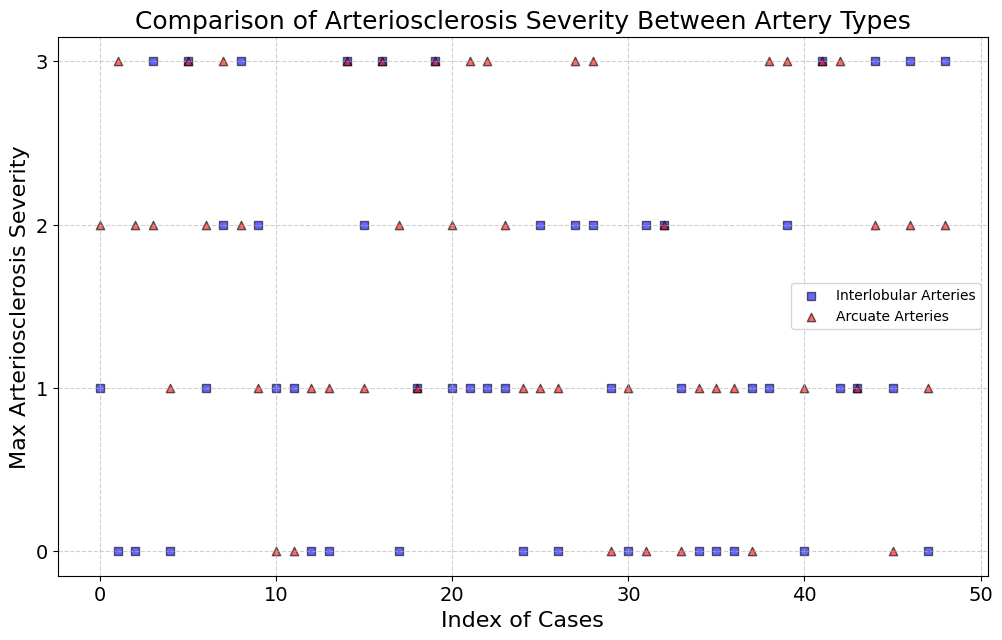

Number of cases where Interlobular Arteries > Arcuate Arteries: 15
Number of cases where Interlobular Arteries < Arcuate Arteries: 26
Number of cases where Interlobular Arteries = Arcuate Arteries: 8
(81, 101)


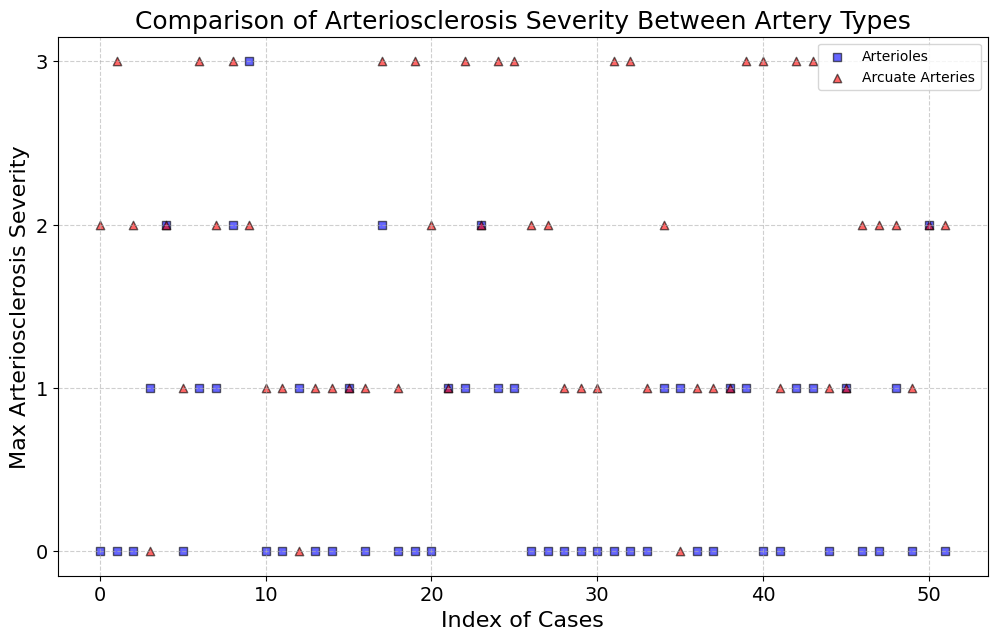

Number of cases where Arterioles > Arcuate Arteries: 4
Number of cases where Arterioles < Arcuate Arteries: 41
Number of cases where Arterioles = Arcuate Arteries: 7


In [12]:
compare_vessel_types(doc, "Interlobular Arteries", "Arcuate Arteries")
compare_vessel_types(doc, "Arterioles", "Arcuate Arteries")

In [13]:
doc.save(ANALYSIS_DOC_PATH)